In [62]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

In [63]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# read Covid-19 SG dataset
sg_data = pd.read_csv(url)
sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

In [64]:
sg_data_filtered.tail()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,Cumulative Deaths,Tested positive demise,Daily Imported,Daily Local transmission,Local cases residing in dorms MOH report,Local cases not residing in doms MOH report,Intensive Care Unit (ICU),General Wards MOH report,In Isolation MOH report,Total Completed Isolation MOH report,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
640,2021-10-24,3383,0.0,172644,3369,0,142620,27993,1708,15,315,0,8,3375,667.0,2708.0,58,1680.0,27993.0,133342.0,9256.0,433.0,NaN,NaN,Stabilisation Phase,9773881.0,4629597.0,4573743.0,85%,84%
641,2021-10-25,3174,0.0,175818,2954,0,145574,28158,1749,14,329,0,9,3165,322.0,2843.0,64,1715.0,28158.0,136237.0,9315.0,432.0,NaN,NaN,Stabilisation Phase,9786082.0,4630558.0,4574892.0,85%,84%
642,2021-10-26,3277,0.0,179095,2856,0,148430,28561,1757,10,339,0,5,3272,288.0,2984.0,67,1720.0,28561.0,138924.0,9484.0,435.0,NaN,NaN,Stabilisation Phase,10003952.0,4731066.0,4670973.0,85%,84%
643,2021-10-27,5324,0.0,184419,3172,0,151602,30713,1747,10,349,0,12,5312,661.0,4651.0,66,1711.0,30713.0,141918.0,9662.0,450.0,NaN,NaN,Stabilisation Phase,10029148.0,4733014.0,4673461.0,85%,84%
644,2021-10-28,3432,0.0,187851,4348,0,155950,29827,1702,15,364,0,9,3423,252.0,3171.0,61,1671.0,29827.0,145992.0,9936.0,430.0,NaN,NaN,Stabilisation Phase,10049015.0,4734669.0,4675888.0,85%,84%


In [65]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          645 non-null    object 
 1   Daily Confirmed                               645 non-null    int64  
 2   False Positives Found                         536 non-null    float64
 3   Cumulative Confirmed                          645 non-null    int64  
 4   Daily Discharged                              645 non-null    int64  
 5   Passed but not due to COVID                   645 non-null    int64  
 6   Cumulative Discharged                         645 non-null    int64  
 7   Discharged to Isolation                       645 non-null    int64  
 8   Still Hospitalised                            645 non-null    int64  
 9   Daily Deaths                                  645 non-null    int

In [66]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [67]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [68]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [69]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [70]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [71]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [72]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               645 non-null    int64  
 1   False Positives Found                         645 non-null    float64
 2   Cumulative Confirmed                          645 non-null    int64  
 3   Daily Discharged                              645 non-null    int64  
 4   Passed but not due to COVID                   645 non-null    int64  
 5   Cumulative Discharged                         645 non-null    int64  
 6   Discharged to Isolation                       645 non-null    int64  
 7   Still Hospitalised                            645 non-null    int64  
 8   Daily Deaths                                  645 non-null    int64  
 9   Cumulative Deaths                             645 non-null    int

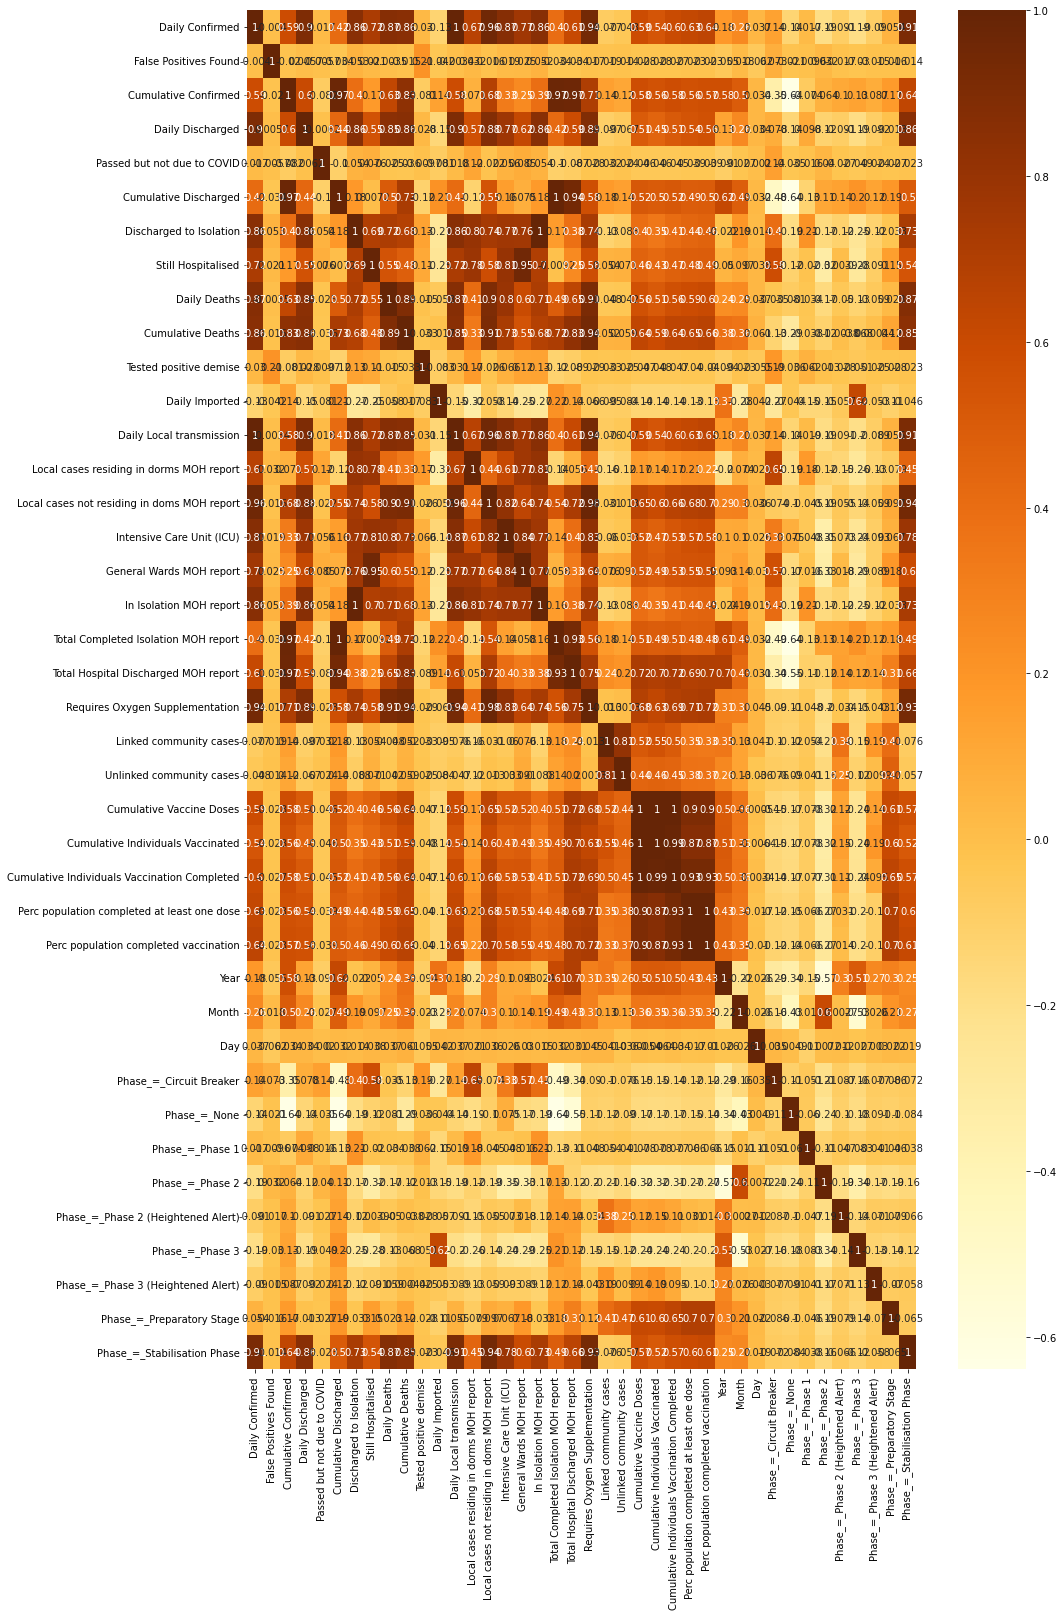

In [73]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [74]:
sg_data_filtered.corr()["Requires Oxygen Supplementation"].sort_values(ascending=False)

Requires Oxygen Supplementation                 1.000000
Local cases not residing in doms MOH report     0.979712
Cumulative Deaths                               0.938894
Daily Confirmed                                 0.936745
Daily Local transmission                        0.935902
Phase_=_Stabilisation Phase                     0.933989
Daily Deaths                                    0.911691
Daily Discharged                                0.890918
Intensive Care Unit (ICU)                       0.828176
Total Hospital Discharged MOH report            0.747513
Discharged to Isolation                         0.737381
In Isolation MOH report                         0.736422
Perc population completed vaccination           0.724320
Cumulative Confirmed                            0.708768
Perc population completed at least one dose     0.708046
Cumulative Individuals Vaccination Completed    0.690110
Cumulative Vaccine Doses                        0.681397
General Wards MOH report       

# Train Test Split & KFold Cross Validation

In [75]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Requires Oxygen Supplementation", axis=1)
y = sg_data_filtered["Requires Oxygen Supplementation"]

In [76]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [77]:
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear regression

In [78]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [79]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for LR
MAE: 4.95496153893606
MSE: 83.08420908687192
RMSE: 9.115053981566534
R-squared score for train: 0.9941508496260852
Adjusted R-squared score for train: 0.9937737969573536
R-squared score for test: 0.9885420525627494
Adjusted R-squared score for test: 0.9878034410750589
Cross Validation Score: 0.9904


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


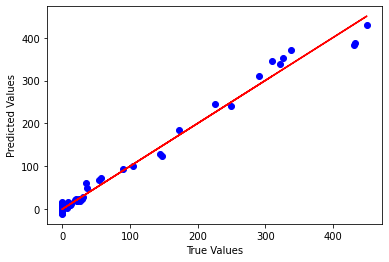

In [80]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

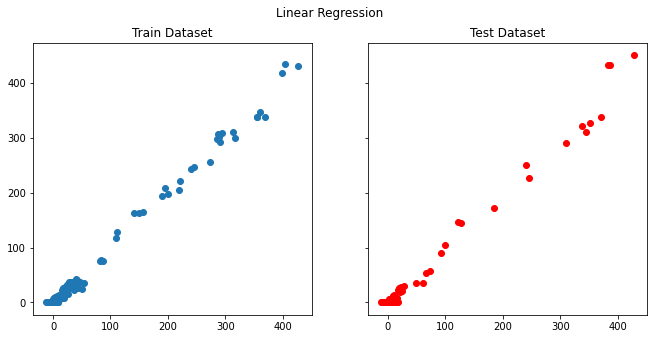

In [81]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [82]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,1.363338e+08
25,Perc population completed at least one dose,7.696205e+02
38,Phase_=_Stabilisation Phase,1.117183e+01
31,Phase_=_None,9.661339e+00
10,Tested positive demise,4.164596e+00
7,Still Hospitalised,3.755290e+00
6,Discharged to Isolation,3.754612e+00
5,Cumulative Discharged,3.623275e+00
37,Phase_=_Preparatory Stage,3.472715e+00
9,Cumulative Deaths,3.106951e+00


# Lasso Regression

In [83]:
# build lasso model

lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19924.03009995029, tolerance: 204.53634906832295
  positive)


In [84]:
# assessing model

train_adjusted_r2 = 1 - (1-lasso.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(lasso, X, y, cv=strat_k_fold)), 4)}")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Evaluation Metrics for Lasso
MAE: 5.394188372724545
MSE: 128.0495610999499
RMSE: 11.31589859887185
R-squared score for train: 0.9811073641300412
Adjusted R-squared score for train: 0.9798894917351182
R-squared score for test: 0.9823409868545279
Adjusted R-squared score for test: 0.9812026372468032


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24691.26189632252, tolerance: 264.75233720930237
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23585.094373636133, tolerance: 263.88698062015504
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21978.024217892907, tolerance: 260.3696253875969
  positive)


Cross Validation Score: 0.9787


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24201.3033210965, tolerance: 255.2520998062016
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23300.363819657727, tolerance: 248.47352480620157
  positive)


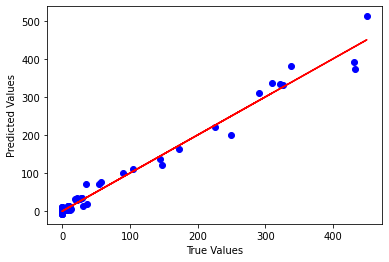

In [85]:
# For test set

# scatter for predictions
plt.scatter(y_test, lasso_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

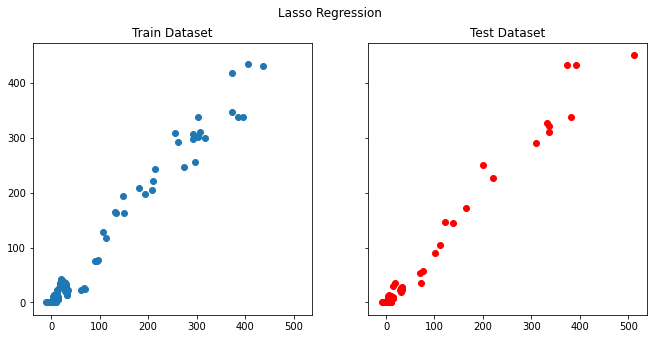

In [86]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso.predict(X_train), y_train)
ax[1].scatter(lasso_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression')

plt.show()

In [87]:
# find out feature importance

lasso_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lasso.coef_
})

lasso_importance = lasso_importance.sort_values(by='Importance', ascending=False)
lasso_importance

,Attribute,Importance
15,Intensive Care Unit (ICU),0.400352
9,Cumulative Deaths,0.307808
0,Daily Confirmed,0.063082
29,Day,0.030661
7,Still Hospitalised,0.007373
3,Daily Discharged,0.006776
6,Discharged to Isolation,0.003366
19,Total Hospital Discharged MOH report,0.002120
2,Cumulative Confirmed,0.000642
22,Cumulative Vaccine Doses,0.000062


In [88]:
## Ridge Regression

In [89]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Ridge
MAE: 4.857760240925725
MSE: 90.35331146336625
RMSE: 9.505435890234926
R-squared score for train: 0.9901822755246034
Adjusted R-squared score for train: 0.9895493974179249
R-squared score for test: 0.9875395877880196
Adjusted R-squared score for test: 0.9867363546041069
Cross Validation Score: 0.987


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.08381e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.90922e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.29122e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.4698e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklear

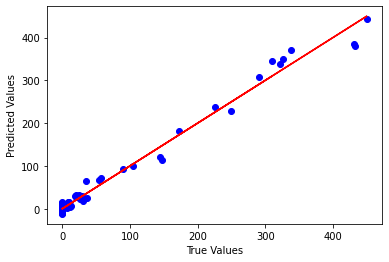

In [90]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

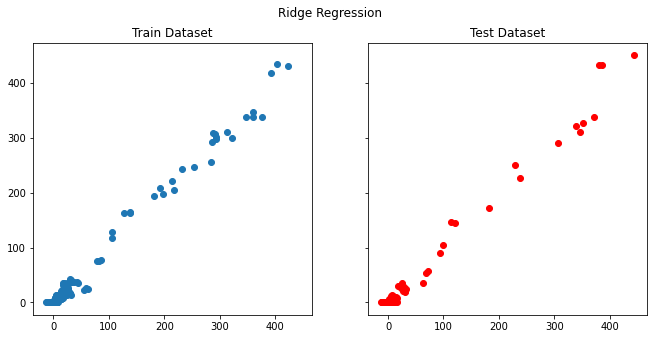

In [91]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [92]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
31,Phase_=_None,15.467229
7,Still Hospitalised,4.848451
6,Discharged to Isolation,4.845921
5,Cumulative Discharged,4.725600
33,Phase_=_Phase 2,4.699416
9,Cumulative Deaths,4.467158
34,Phase_=_Phase 2 (Heightened Alert),4.316372
36,Phase_=_Phase 3 (Heightened Alert),3.949401
35,Phase_=_Phase 3,2.994726
25,Perc population completed at least one dose,2.959614


# Important Features & Future Prediction

In [ ]:
important_X_train = X_train[["Still Hospitalised","Discharged to Isolation","Cumulative Discharged","Cumulative Deaths","Perc population completed at least one dose","Tested positive demise","Intensive Care Unit (ICU)","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Still Hospitalised","Discharged to Isolation","Cumulative Discharged","Cumulative Deaths","Perc population completed at least one dose","Tested positive demise","Intensive Care Unit (ICU)","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()